# OOP II: Building Classes

In [18]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.integrate import quad

## Defining Your Own Classes

In [2]:
class Consumer:

    def __init__(self, w):
        self.wealth = w

    def earn(self, y):
        self.wealth += y

    def spend(self, x):
        new_wealth = self.wealth - x
        if new_wealth < 0:
            print("Insufficent funds")
        else:
            self.wealth = new_wealth

In [12]:
c1 = Consumer(20)
c1.spend(10)
print(str(c1.wealth))

c1.earn(15)
c1.spend(100)

c2 = Consumer(12)
c2.spend(4)
Consumer.spend(c2, 200)    # Equivalent to the previous call
print(str(c2.wealth))

10
Insufficent funds
Insufficent funds
8


In [10]:
print(c1.__dict__)
print(c2.__dict__)
print(Consumer.__dict__)

{'wealth': 25}
{'wealth': 8}
{'__module__': '__main__', '__init__': <function Consumer.__init__ at 0x000002108EBA2678>, 'earn': <function Consumer.earn at 0x000002108EBA2708>, 'spend': <function Consumer.spend at 0x000002108EBA2798>, '__dict__': <attribute '__dict__' of 'Consumer' objects>, '__weakref__': <attribute '__weakref__' of 'Consumer' objects>, '__doc__': None}


## Example: The Solow Growth Model

In [13]:
class Solow:
    r"""
    Implements the Solow growth model with the update rule

        k_{t+1} = [(s z k^α_t) + (1 - δ)k_t] /(1 + n)

    """
    def __init__(self, n=0.05,  # population growth rate
                       s=0.25,  # savings rate
                       δ=0.1,   # depreciation rate
                       α=0.3,   # share of labor
                       z=2.0,   # productivity
                       k=1.0):  # current capital stock

        self.n, self.s, self.δ, self.α, self.z = n, s, δ, α, z
        self.k = k

    def h(self):
        "Evaluate the h function"
        # Unpack parameters (get rid of self to simplify notation)
        n, s, δ, α, z = self.n, self.s, self.δ, self.α, self.z
        # Apply the update rule
        return (s * z * self.k**α + (1 - δ) * self.k) / (1 + n)

    def update(self):
        "Update the current state (i.e., the capital stock)."
        self.k =  self.h()

    def steady_state(self):
        "Compute the steady state value of capital."
        # Unpack parameters (get rid of self to simplify notation)
        n, s, δ, α, z = self.n, self.s, self.δ, self.α, self.z
        # Compute and return steady state
        return ((s * z) / (n + δ))**(1 / (1 - α))

    def generate_sequence(self, t):
        "Generate and return a time series of length t"
        path = []
        for i in range(t):
            path.append(self.k)
            self.update()
        return path

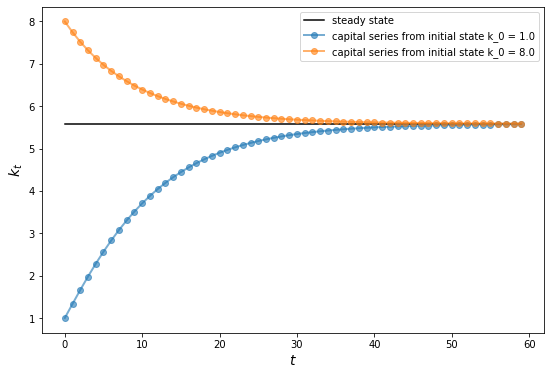

In [17]:
s1 = Solow()
s2 = Solow(k=8.0)

T = 60
fig, ax = plt.subplots(figsize=(9, 6))

# Plot the common steady state value of capital
ax.plot([s1.steady_state()]*T, 'k-', label='steady state')

# Plot time series for each economy
for s in s1, s2:
    lb = f'capital series from initial state k_0 = {s.k}'
    ax.plot(s.generate_sequence(T), 'o-', lw=2, alpha=0.6, label=lb)

ax.set_xlabel('$t$', fontsize=14)
ax.set_ylabel('$k_t$', fontsize=14)
ax.legend()
plt.show()

## Example: A Market

In [30]:
class Market:

    def __init__(self, ad, bd, az, bz, tax):
        """
        Set up market parameters.  All parameters are scalars.  See
        https://lectures.quantecon.org/py/python_oop.html for interpretation.

        """
        self.ad, self.bd, self.az, self.bz, self.tax = ad, bd, az, bz, tax
        if ad < az:
            raise ValueError('Insufficient demand.')

    def price(self):
        "Compute equilibrium price"
        return  (self.ad - self.az + self.bz * self.tax) / (self.bd + self.bz)

    def quantity(self):
        "Compute equilibrium quantity"
        return  self.ad - self.bd * self.price()

    def consumer_surp(self):
        "Compute consumer surplus"
        # == Compute area under inverse demand function == #
        integrand = lambda x: (self.ad / self.bd) - (1 / self.bd) * x
        area, error = quad(integrand, 0, self.quantity())
        return area - self.price() * self.quantity()

    def producer_surp(self):
        "Compute producer surplus"
        #  == Compute area above inverse supply curve, excluding tax == #
        integrand = lambda x: -(self.az / self.bz) + (1 / self.bz) * x
        area, error = quad(integrand, 0, self.quantity())
        return (self.price() - self.tax) * self.quantity() - area

    def taxrev(self):
        "Compute tax revenue"
        return self.tax * self.quantity()

    def inverse_demand(self, x):
        "Compute inverse demand"
        return self.ad / self.bd - (1 / self.bd)* x

    def inverse_supply(self, x):
        "Compute inverse supply curve"
        return -(self.az / self.bz) + (1 / self.bz) * x + self.tax

    def inverse_supply_no_tax(self, x):
        "Compute inverse supply curve without tax"
        return -(self.az / self.bz) + (1 / self.bz) * x

In [21]:
baseline_params = 15, .5, -2, .5, 3
m = Market(*baseline_params)
print("equilibrium price = ", m.price())

print("consumer surplus = ", m.consumer_surp())

equilibrium price =  18.5
consumer surplus =  33.0625


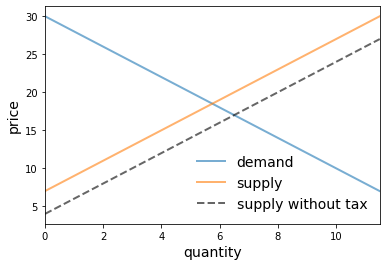

In [22]:
# Baseline ad, bd, az, bz, tax
baseline_params = 15, .5, -2, .5, 3
m = Market(*baseline_params)

q_max = m.quantity() * 2
q_grid = np.linspace(0.0, q_max, 100)
pd = m.inverse_demand(q_grid)
ps = m.inverse_supply(q_grid)
psno = m.inverse_supply_no_tax(q_grid)

fig, ax = plt.subplots()
ax.plot(q_grid, pd, lw=2, alpha=0.6, label='demand')
ax.plot(q_grid, ps, lw=2, alpha=0.6, label='supply')
ax.plot(q_grid, psno, '--k', lw=2, alpha=0.6, label='supply without tax')
ax.set_xlabel('quantity', fontsize=14)
ax.set_xlim(0, q_max)
ax.set_ylabel('price', fontsize=14)
ax.legend(loc='lower right', frameon=False, fontsize=14)
plt.show()

In [31]:
def deadw(m):
    "Computes deadweight loss for market m."
    # == Create analogous market with no tax == #
    m_no_tax = Market(m.ad, m.bd, m.az, m.bz, 0)
    # == Compare surplus, return difference == #
    surp1 = m_no_tax.consumer_surp() + m_no_tax.producer_surp()
    surp2 = m.consumer_surp() + m.producer_surp() + m.taxrev()
    return surp1 - surp2

baseline_params = 15, .5, -2, .5, 3
m = Market(*baseline_params)
deadw(m)  # Show deadweight loss

1.125

## Special Metods

In [8]:
class Foo:
    def __len__(self):
        return 42
    
    def __call__(self):
        print('This is a call to all my past resignations')

In [9]:
f = Foo()
print(f'len(f): {len(f)}')

x = (1, 2)
print(f'len(x): {len(x)}')

f = Foo()
f()

len(f): 42
len(x): 2
This is a call to all my past resignations
